In [1]:
import numpy as np
import pandas as pd
import random
import os

SEED = 1234
np.random.seed(SEED)
pd.core.common._random_stat = SEED
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [2]:
from google.colab import drive
drive.mount('/content/MyDrive')

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [3]:
! unzip /content/MyDrive/MyDrive/AppliedAIinBiomedicine/final-assignment/features_complete.zip

Archive:  /content/MyDrive/MyDrive/AppliedAIinBiomedicine/final-assignment/features_complete.zip
replace features_complete.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [48]:
features = pd.read_csv('/content/features_complete.csv', index_col=0)
features.describe()

,PR_interval,QR_interval,rr_intervals,drr_intervals,rr_mean_2_min_window_centered,rr_std_2_min_window_centered,drr_mean_2_min_window_centered,drr_std_2_min_window_centered,rmssd_2_min_window_centered,rr_std_5_min_window_centered,drr_mean_5_min_window_centered,drr_std_5_min_window_centered,rmssd_5_min_window_centered,rr_mean_2_min_before,rr_std_2_min_window_before,drr_mean_2_min_window_before,drr_std_2_min_window_before,rmssd_2_min_window_before,rr_mean_5_min_window_before,rr_std_5_min_window_before,drr_mean_5_min_window_before,drr_std_5_min_before,rmssd_5_min_window_before,max_corrs_win_4,lag_max_corrs_win_4,max_corrs_win_20,lag_max_corrs_win_20
count,210965.000000,188303.000000,1714.000000,1712.000000,198660.000000,198660.000000,198660.000000,198660.000000,198660.000000,177336.000000,1.773360e+05,177336.000000,177336.000000,198606.000000,198606.000000,198606.000000,198606.000000,198606.000000,177057.000000,177057.000000,177057.000000,177057.000000,177057.000000,212572.000000,212572.000000,210412.000000,210412.000000
mean,0.148584,0.275726,1.049580,-0.000208,0.760666,0.073845,-0.000107,0.109588,0.767652,0.078118,7.191758e-07,0.113666,0.768120,0.761576,0.067092,-0.000195,0.102928,0.768094,0.762522,0.072146,-0.000034,0.107970,0.769496,13.091457,25.461679,13.026445,25.477563
std,0.202605,0.093774,0.062507,0.028625,0.171898,0.084254,0.007310,0.136120,0.177266,0.084124,4.608158e-03,0.134700,0.176273,0.174772,0.087979,0.014650,0.143758,0.181153,0.173256,0.087744,0.009124,0.141190,0.179547,16.909313,41.834657,16.481153,41.710051
min,-12.312500,0.068000,0.628000,-0.432000,0.250355,0.001949,-0.524858,0.002853,0.253028,0.002943,-3.382353e-01,0.003906,0.256250,0.249645,0.000000,-1.168750,0.000000,0.250311,0.247098,0.001561,-0.682904,0.002255,0.249004,0.000684,-74.000000,0.013689,-74.000000
25%,0.164062,0.209469,1.024000,-0.012000,0.638951,0.017584,-0.001420,0.017138,0.642764,0.022462,-9.411765e-04,0.019208,0.643723,0.637714,0.012956,-0.002545,0.014573,0.641350,0.638139,0.015880,-0.001736,0.016383,0.642100,2.244225,-3.000000,2.242081,-3.000000
50%,0.192000,0.304000,1.056000,0.000000,0.750930,0.051774,0.000000,0.065859,0.756529,0.059113,0.000000e+00,0.079369,0.757539,0.750154,0.032959,0.000000,0.035148,0.755533,0.750781,0.046431,0.000000,0.054311,0.756109,8.414843,6.000000,8.352982,6.000000
75%,0.224000,0.343750,1.088000,0.012000,0.885530,0.105996,0.001385,0.162664,0.892802,0.107148,9.302326e-04,0.163920,0.894389,0.886719,0.099724,0.002404,0.155827,0.893595,0.889323,0.104317,0.001645,0.161539,0.896282,17.817314,66.000000,17.720483,66.000000
max,0.695312,0.609375,1.224000,0.596000,2.540865,2.988946,0.551711,4.258109,3.748766,2.338192,3.314732e-01,3.201504,2.889515,4.556641,4.623242,1.429688,7.673220,6.491328,2.882812,3.486445,0.833705,5.117447,4.444366,652.306495,268.000000,452.248197,232.000000


In [49]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(features, test_size=0.25, random_state=SEED, shuffle=True, stratify=features['target'])

train_target = train.target
train_features = train.drop(columns='target')

test_target = test.target
test_features = test.drop(columns='target')

In [50]:
train_features.describe()

,PR_interval,QR_interval,rr_intervals,drr_intervals,rr_mean_2_min_window_centered,rr_std_2_min_window_centered,drr_mean_2_min_window_centered,drr_std_2_min_window_centered,rmssd_2_min_window_centered,rr_std_5_min_window_centered,drr_mean_5_min_window_centered,drr_std_5_min_window_centered,rmssd_5_min_window_centered,rr_mean_2_min_before,rr_std_2_min_window_before,drr_mean_2_min_window_before,drr_std_2_min_window_before,rmssd_2_min_window_before,rr_mean_5_min_window_before,rr_std_5_min_window_before,drr_mean_5_min_window_before,drr_std_5_min_before,rmssd_5_min_window_before,max_corrs_win_4,lag_max_corrs_win_4,max_corrs_win_20,lag_max_corrs_win_20
count,158229.000000,141231.000000,1305.000000,1.303000e+03,149061.000000,149061.000000,149061.000000,149061.000000,149061.000000,132958.000000,132958.000000,132958.000000,132958.000000,148929.000000,148929.000000,148929.000000,148929.000000,148929.000000,132818.000000,132818.000000,132818.000000,132818.000000,132818.000000,159421.000000,159421.000000,157796.000000,157796.000000
mean,0.149006,0.275745,1.049891,-1.504221e-04,0.760622,0.073855,-0.000106,0.109594,0.767636,0.078115,0.000004,0.113688,0.768009,0.761445,0.067073,-0.000218,0.102869,0.767983,0.762403,0.072130,-0.000046,0.107934,0.769398,13.107848,25.462223,13.037825,25.466666
std,0.202234,0.093845,0.061672,3.029910e-02,0.171967,0.084889,0.007334,0.136768,0.177519,0.084623,0.004661,0.135352,0.176563,0.175179,0.089309,0.014403,0.145389,0.182109,0.173480,0.088672,0.008888,0.142431,0.180128,17.049378,41.844666,16.537492,41.714728
min,-12.312500,0.068000,0.628000,-4.320000e-01,0.250533,0.001949,-0.524858,0.002853,0.253190,0.002943,-0.338235,0.003906,0.256250,0.249645,0.000000,-1.168750,0.000000,0.250311,0.247098,0.001561,-0.682904,0.002255,0.249004,0.000684,-72.000000,0.016698,-74.000000
25%,0.164062,0.208000,1.024000,-1.200000e-02,0.638672,0.017573,-0.001400,0.017106,0.642635,0.022398,-0.000930,0.019168,0.643551,0.637277,0.012941,-0.002545,0.014558,0.641227,0.637818,0.015854,-0.001736,0.016343,0.641832,2.250181,-3.000000,2.246243,-3.000000
50%,0.192000,0.304000,1.056000,2.842171e-14,0.750901,0.051696,0.000000,0.065771,0.756500,0.059087,0.000000,0.079352,0.757476,0.750154,0.032883,0.000000,0.034996,0.755486,0.750400,0.046327,0.000000,0.053973,0.755981,8.427759,6.000000,8.367355,6.000000
75%,0.224000,0.343750,1.088000,1.200000e-02,0.885417,0.105897,0.001395,0.162626,0.892622,0.107139,0.000941,0.163994,0.894264,0.886719,0.099655,0.002404,0.155678,0.893242,0.888889,0.104375,0.001645,0.161721,0.895994,17.834752,66.000000,17.742852,66.000000
max,0.687500,0.568000,1.220000,5.960000e-01,2.540865,2.944563,0.255729,4.103390,3.626088,2.294856,0.331473,3.134095,2.834308,4.556641,4.623242,0.583984,7.673220,6.491328,2.882812,3.486445,0.394531,5.117447,4.444366,652.306495,268.000000,452.248197,232.000000


In [51]:
#replace nan values with zeros
for key in train_features.keys():
  train_features[key] = train_features[key].fillna(0)

In [52]:
train_features.head()

,PR_interval,QR_interval,rr_intervals,drr_intervals,rr_mean_2_min_window_centered,rr_std_2_min_window_centered,drr_mean_2_min_window_centered,drr_std_2_min_window_centered,rmssd_2_min_window_centered,rr_std_5_min_window_centered,drr_mean_5_min_window_centered,drr_std_5_min_window_centered,rmssd_5_min_window_centered,rr_mean_2_min_before,rr_std_2_min_window_before,drr_mean_2_min_window_before,drr_std_2_min_window_before,rmssd_2_min_window_before,rr_mean_5_min_window_before,rr_std_5_min_window_before,drr_mean_5_min_window_before,drr_std_5_min_before,rmssd_5_min_window_before,max_corrs_win_4,lag_max_corrs_win_4,max_corrs_win_20,lag_max_corrs_win_20
194952,0.196000,0.184000,0.0,0.0,0.588000,0.085189,-0.001429,0.143253,0.594139,0.000000,0.000000,0.000000,0.000000,0.591429,0.086399,0.000571,0.145247,0.597706,0.593043,0.068058,0.002087,0.113413,0.596936,28.332666,79.0,27.188629,80.0
36740,0.179688,0.000000,0.0,0.0,0.657986,0.672569,0.005787,0.982834,0.940901,0.532602,-0.004084,0.776887,0.820071,0.528125,0.069104,-0.004167,0.128400,0.532627,0.538086,0.072671,-0.012044,0.116665,0.542971,71.465338,-11.0,72.885354,-11.0
39070,0.125000,0.203125,0.0,0.0,0.446970,0.011175,0.000000,0.014521,0.447109,0.010490,0.000300,0.014451,0.447389,0.440717,0.009305,0.000460,0.015503,0.440815,0.442007,0.008979,0.000601,0.014684,0.442098,0.602791,-24.0,0.708067,-24.0
83317,0.156250,0.351562,0.0,0.0,0.750000,0.181430,-0.020132,0.291474,0.771633,0.186284,0.000953,0.297302,0.765763,0.707933,0.194229,-0.025240,0.307566,0.734094,0.680432,0.180292,0.007440,0.306911,0.703912,67.563248,8.0,73.594425,8.0
24980,0.210938,0.257812,0.0,0.0,0.757500,0.114383,0.002188,0.191322,0.766087,0.101895,0.002148,0.169407,0.763084,0.770182,0.146730,0.010417,0.247553,0.784035,0.774219,0.124802,0.005859,0.211946,0.784213,2.190587,6.0,2.484710,6.0


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:185: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


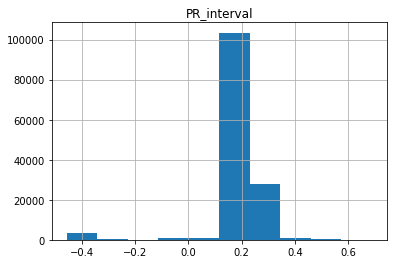

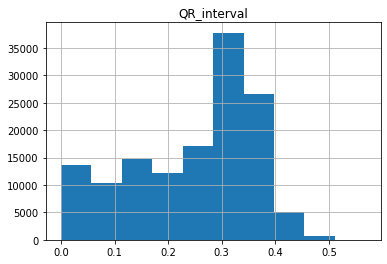

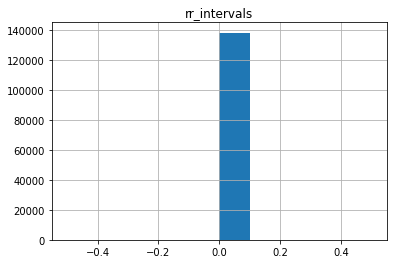

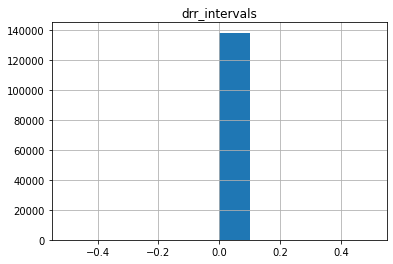

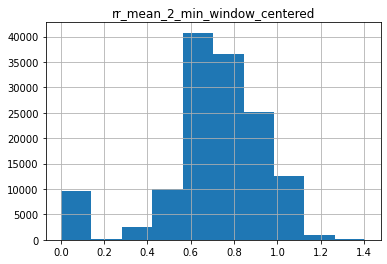

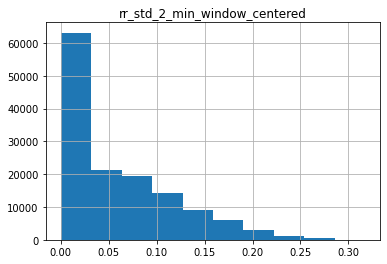

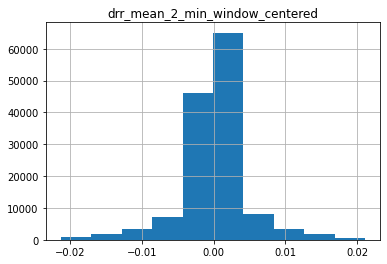

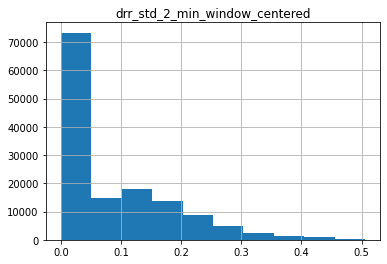

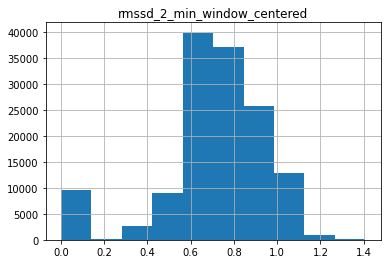

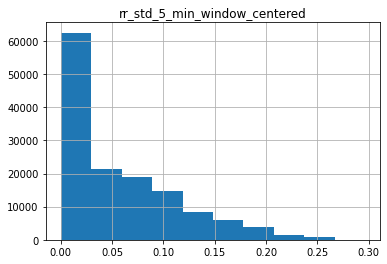

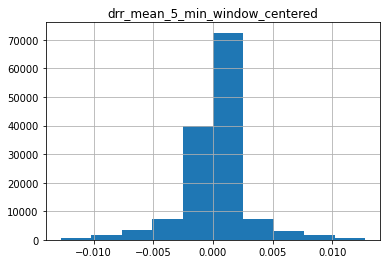

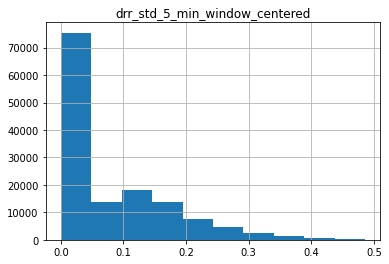

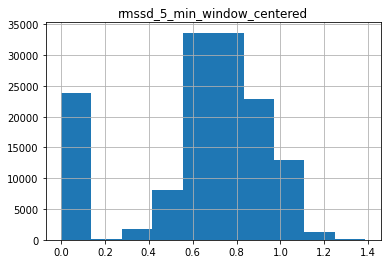

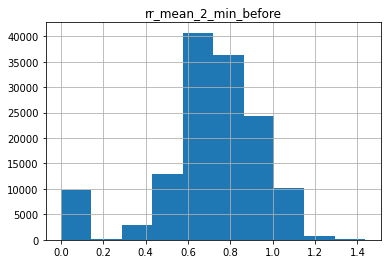

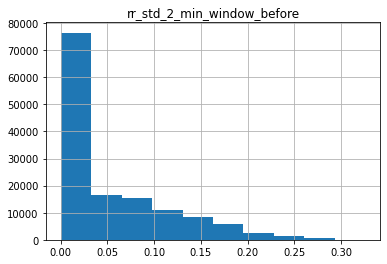

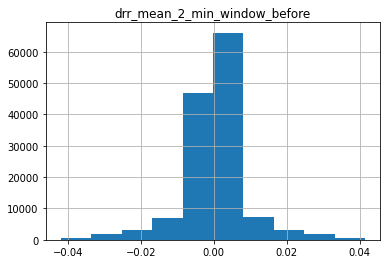

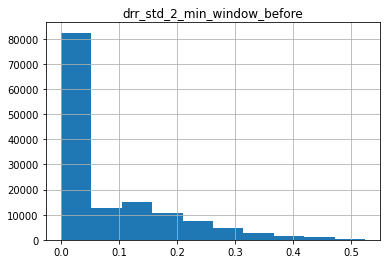

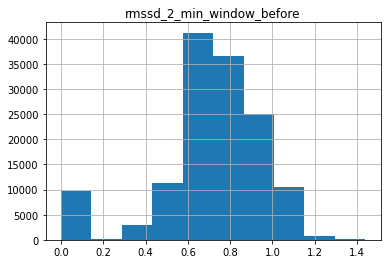

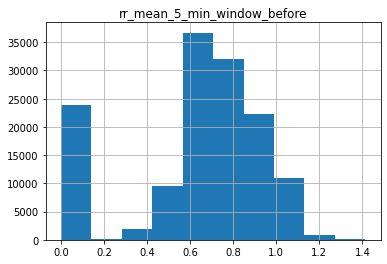

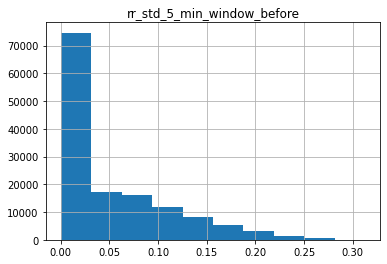

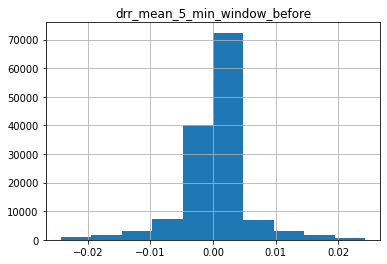

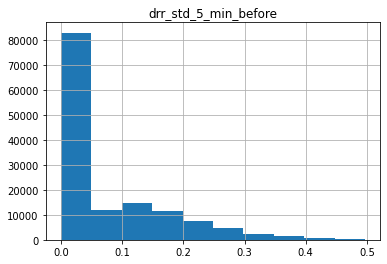

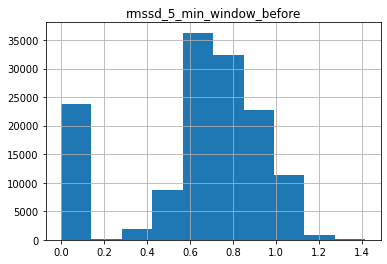

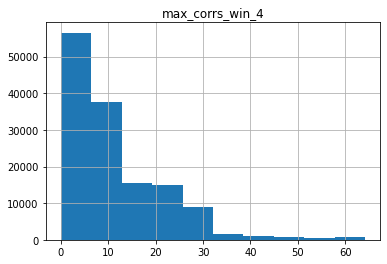

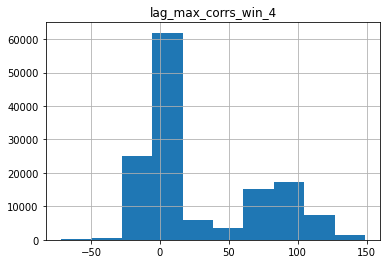

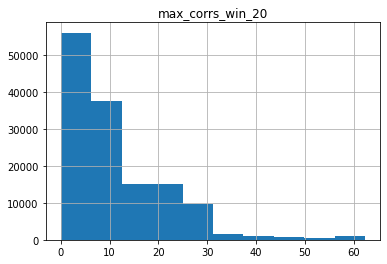

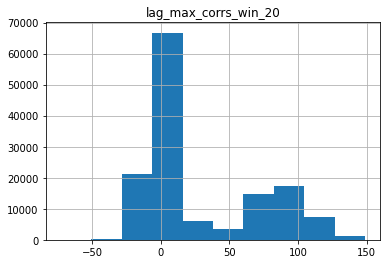

In [18]:
for column in train_features.columns:
  train_features.hist(column=column)

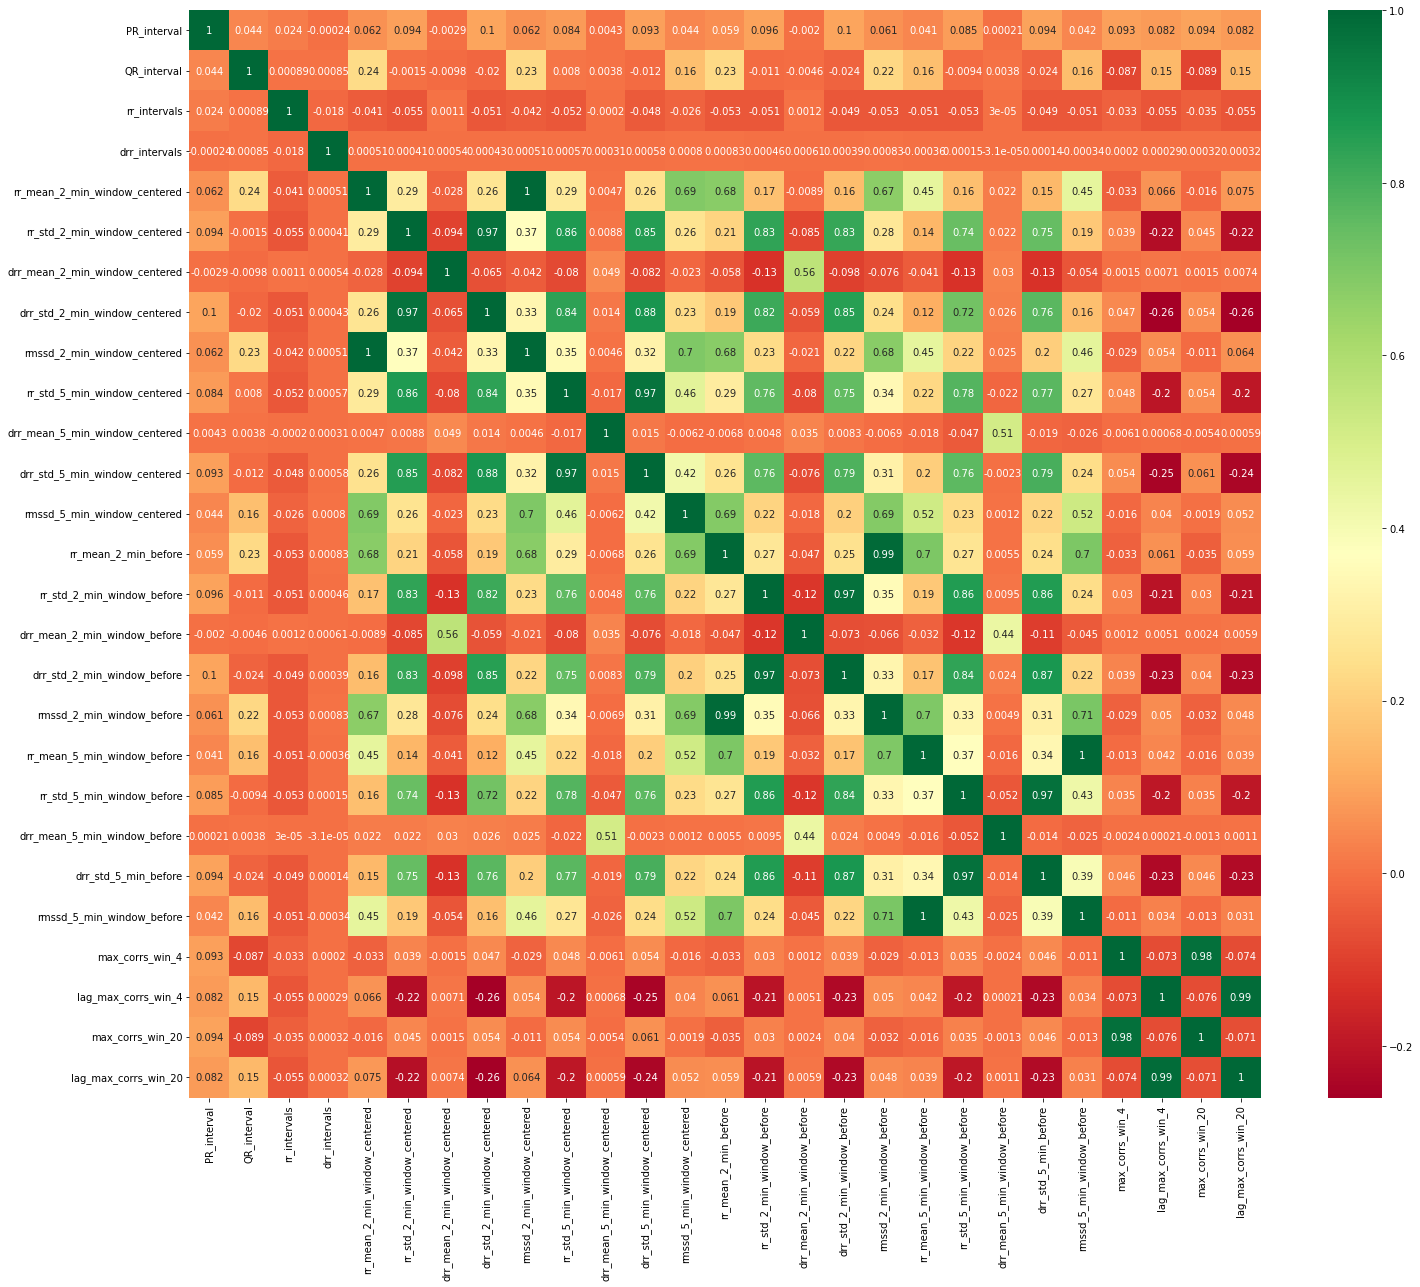

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(24,20))  # on this line I just set the size of figure to 12 by 10.
p=sns.heatmap(train_features.corr(), annot=True,cmap ='RdYlGn')  # seaborn has very simple solution for heatmap

In [20]:
# 2. Standarize data with RobustScaler transformation
from sklearn.preprocessing import RobustScaler

transformer = RobustScaler().fit(train_features)
features_list = train_features.columns.tolist()
train_features_zscore = transformer.transform(train_features)
#Transform the numpy array back to a dataframe
train_features = pd.DataFrame(data=train_features_zscore, columns=features_list)

In [54]:
"Training a Baseline Model"
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
logisticRegression = LogisticRegression(random_state=SEED, class_weight='balanced')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=SEED)

score = cross_val_score(logisticRegression, train_features, train_target, scoring='f1_macro', cv=cv, n_jobs=-1, error_score='raise', verbose=1)
print(np.mean(score))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0.3955422179837957


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   59.1s finished


Estimation of the feature importance using Ensamble Tree

In [55]:
from sklearn.ensemble import ExtraTreesClassifier

randomForest = ExtraTreesClassifier(n_estimators=250, class_weight='balanced', random_state = SEED)
randomForest.fit(train_features, train_target)


ExtraTreesClassifier(class_weight='balanced', n_estimators=250,
                     random_state=1234)

In [56]:
importances = randomForest.feature_importances_
std = np.std([tree.feature_importances_ for tree in randomForest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train_features.shape[1]):
    print("%2d. feature %2d %7s (%.3f)" % (f + 1, indices[f], feature_list[indices[f]], importances[indices[f]]))

Feature ranking:
 1. feature 16 drr_std_2_min_window_before (0.070)
 2. feature 26 lag_max_corrs_win_20 (0.056)
 3. feature 14 rr_std_2_min_window_before (0.054)
 4. feature  7 drr_std_2_min_window_centered (0.054)
 5. feature 15 drr_mean_2_min_window_before (0.050)
 6. feature 24 lag_max_corrs_win_4 (0.050)
 7. feature 25 max_corrs_win_20 (0.047)
 8. feature  5 rr_std_2_min_window_centered (0.047)
 9. feature  1 QR_interval (0.046)
10. feature 23 max_corrs_win_4 (0.045)
11. feature 21 drr_std_5_min_before (0.043)
12. feature 20 drr_mean_5_min_window_before (0.040)
13. feature 13 rr_mean_2_min_before (0.037)
14. feature 11 drr_std_5_min_window_centered (0.036)
15. feature  0 PR_interval (0.035)
16. feature 17 rmssd_2_min_window_before (0.035)
17. feature  4 rr_mean_2_min_window_centered (0.034)
18. feature 19 rr_std_5_min_window_before (0.034)
19. feature  8 rmssd_2_min_window_centered (0.032)
20. feature  9 rr_std_5_min_window_centered (0.031)
21. feature 18 rr_mean_5_min_window_befor

Detection of low variance features

In [61]:
from sklearn.feature_selection import VarianceThreshold
feature_selection_variance_model = VarianceThreshold(threshold=0.0001)
X_selected_features_variance = feature_selection_variance_model.fit_transform(train_features)


mask = feature_selection_variance_model.get_support() #list of booleans
for feature in feature_list:
  if(mask[features_list.index(feature)] == False):
    print(feature, "Discarded") 

drr_intervals Discarded
drr_mean_2_min_window_centered Discarded
drr_mean_5_min_window_centered Discarded
drr_mean_5_min_window_before Discarded


In [68]:
logisticRegression = LogisticRegression(random_state=SEED, class_weight='balanced')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=SEED)

score = cross_val_score(logisticRegression, train_features[['drr_std_2_min_window_before','lag_max_corrs_win_20', 'rr_std_2_min_window_before', 'drr_std_2_min_window_centered']], train_target, scoring='f1_macro', cv=cv, n_jobs=-1, error_score='raise', verbose=1)
print(np.mean(score))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0.40165454204799017


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.4min finished
